

A tutorial for connecting GRASS and Python can be found [here](https://github.com/chaedri/GIS714-assignments/blob/main/Topic1_Foundations/JupyterOnWindows_Tutorial.ipynb).

`set PATH=%PATH%;C:\Program Files\GRASS GIS 8.2\`

`set PATH=%PATH%;C:\Users\tgest\AppData\Roaming\Python\python39\Scripts`

`jupyter lab --notebook-dir=D:`

In [1]:
# Import Python standard library and IPython packages we need.
import os
import sys
import subprocess
import matplotlib.pyplot as plt

from IPython.display import Image

# Ask GRASS GIS where its Python packages are.
grass_call = "grass82"
sys.path.append(
    subprocess.check_output([grass_call, "--config", "python_path"], text=True, shell=True).strip()
)

# Import the GRASS GIS packages we need.
import grass.script as gs
import grass.jupyter as gj

# Create a GRASS GIS session.
gj.init("D:/GLISA-WWA", "WWA", "Hindcasting22")
os.chdir(r'D:\GLISA-WWA\Paper_runs\Colorado_springs')

The following code chunk defines a function for doing hindcasting runs. Later I may make it more general so as to allow greater flexibility in predictors.

In [2]:
def run_hindcasting(disc_factor, comp_mean, comp_range, repeat=10):
    gs.run_command('r.futures.parallelpga', 
                   overwrite=True,
                   subregions='Counties_22_ras', 
                   developed='urban_2001',
                   predictors='Cost_dist_resc,DEM_resc,WB_dist_resc,Slope_WWA,Canopy2016,OvPass_resc,Dist_prot_resc,Floodplain,public_school_dist_resc,WWA_buildings_resc,wildfire_resc',
                   devpot_params='CS_Pueblo_ss_round3.csv', 
                   development_pressure='devpressure_big_2001@Devpressure',
                   n_dev_neighbourhood=30, 
                   development_pressure_approach='gravity', 
                   gamma=0.5, 
                   scaling_factor=0.1,
                   demand='hindcast_demand2016.csv', 
                   discount_factor=disc_factor, compactness_mean=comp_mean, compactness_range=comp_range,
                   patch_sizes='patches22_hind.txt', 
                   num_neighbors=4, 
                   seed_search='probability',
                   output='hindcast', 
                   nprocs=5, 
                   repeat=repeat)   

The functions below are used to calculate the K_sim value for a run. `chgstats` takes in two rasters and returns an ordered tuple of pixel counts for each change category. `kappa_sim` calculates the kappa score from the outputs of `chgstats` for the actual T1 and T2 maps and the simulation result at T2.  

In [3]:
def chgstats(raster1, raster2):
    urban_to_urban = urban_to_non = non_to_non = non_to_urban = 0
    chstats = gs.read_command('r.stats', flags = 'c', input=raster1+','+raster2)
    for line in chstats.strip().splitlines():
        cat1,cat2,cells = line.split()
        if cat1 == '1' and cat2 == '1':
            urban_to_urban += int(cells)
        elif cat1 == '1' and cat2 == '0':
            urban_to_non += int(cells)
        elif cat1 == '0' and cat2 == '0':
            non_to_non += int(cells)
        elif cat1 == '0' and cat2 == '1':
            non_to_urban += int(cells)
    return (non_to_non, non_to_urban, urban_to_non, urban_to_urban)

def kappa_sim(pre_post_chg, pre_sim_chg, post_sim_diff): #enter four-element vectors
    #check maps are same
    if sum(pre_post_chg) != sum(pre_sim_chg) or sum(post_sim_diff) != sum(pre_sim_chg):
        raise Exception('Maps not the same number of pixels')
    else:
        pix_tot = sum(pre_post_chg)
        
    orig0sim0 = pre_sim_chg[0] # number of cells where the original map is 0 and the simulated map is 0
    orig0sim1 = pre_sim_chg[1] # number of cells where the original map is 0 and the simulated map is 1
    orig1sim0 = pre_sim_chg[2] # etc.
    orig1sim1 = pre_sim_chg[3]
    
    orig0act0 = pre_post_chg[0]
    orig0act1 = pre_post_chg[1]
    orig1act0 = pre_post_chg[2]
    orig1act1 = pre_post_chg[3]
    
    act0sim0 = post_sim_diff[0]
    act1sim1 = post_sim_diff[3]
    
    orig0 = orig0sim0 + orig0sim1
    orig1 = orig1sim0 + orig1sim1
    
    act0 = orig0act0 + orig1act0
    act1 = orig0act1 + orig1act1
    
    sim0 = orig0sim0 + orig1sim0
    sim1 = orig0sim1 + orig1sim1
    
    # observed accuracy
    P_o = (act0sim0 + act1sim1) / pix_tot
    #print("P_o: ", P_o)
    
    # standard expected accuracy
    P_e = (1 / pix_tot**2) * (act1 * sim1 + act0 * sim0)
    
    #max accuracy
    P_max = min(act0 / pix_tot, sim0 / pix_tot) + min(act1 / pix_tot, sim1 / pix_tot)
    #print("P_max: ", P_max)
    
    #sum weighted expected accuracy
    wea1 = ((orig0sim0*orig0act0 + orig0sim1*orig0act1)/(orig0**2))*(orig0 / pix_tot)
    wea2 = ((orig1sim0*orig1act0 + orig1sim1*orig1act1)/(orig1**2))*(orig1 / pix_tot)
    P_e_trans = wea1 + wea2
    #print("P_e_trans: ", P_e_trans, "WEA:", wea1, wea2)
    
    #max agreement for each landuse
    P_max_trans = (((min(orig0sim0,orig0act0)/orig0 + min(orig0sim1,orig0act1)/orig0)*(orig0 / pix_tot)) +
                   ((min(orig1sim0,orig1act0)/orig1 + min(orig1sim1,orig1act1)/orig1)*(orig1 / pix_tot)))
    #print("P_max_trans: ", P_max_trans)
    
    Kappa_cohen = (P_o - P_e) / (1 - P_e)
    Khist = (P_max - P_e_trans) / (1 - P_e_trans)
    Ktranshist = (P_max_trans - P_e_trans) / (P_max - P_e_trans)
    Ktransloc = (P_o - P_e_trans) / (P_max_trans - P_e_trans)
    
    K_sim = Khist * Ktranshist * Ktransloc
    #print("Ksim:", K_sim,"Khist:", Khist,"Ktranshist:", Ktranshist,"Ktransloc:", Ktransloc, "Cohen's Kappa:", Kappa_cohen)
    return K_sim

In [4]:
#pre_post_chg, pre_sim_chg, post_sim_diff
#non_to_non, non_to_urban, urban_to_non, urban_to_urban
kappa_sim((6322489,218414,76,1571218), (6322578,218325,40,1571254), (6126057,196561,196508,1593071))

0.06916206708547826

In [5]:
#chgstats('hind_2001','hind_2019')
pre_post_chg = chgstats('hind_2001', 'hind_2016')
print(pre_post_chg)
pre_sim_chg = chgstats('hind_2001', 'hindcast_run1')
print(pre_sim_chg)
#post_sim_diff = chgstats('hind_2016', 'hindcast_run1')
post_sim_diff = chgstats('hindcast_run1', 'hind_2016')
print(post_sim_diff)

(13297226, 116546, 0, 816351)
(0, 0, 816351, 0)
(0, 816351, 0, 0)


In [6]:
kappa_sim(pre_post_chg, pre_sim_chg, post_sim_diff)

Exception: Maps not the same number of pixels

In [7]:
# remove previous mask
gs.run_command('r.mask', flags = 'r')
#re-add
gs.run_command('r.mask', raster='statsmask')

In [8]:
import pandas as pd

def variance(data):
    n = len(data)
    mean = sum(data) / n
    deviations = [(x - mean) ** 2 for x in data]
    variance = sum(deviations) / n
    return variance

0.13028979461351034 8.531311574070314e-05 for parameter combination 0.1 0.1 0.1
1 out of 100
0.12974060074031205 0.00010396306715005046 for parameter combination 0.1 0.1 0.07
2 out of 100
0.1277046067247526 0.00012201789777513331 for parameter combination 0.1 0.1 0.05
3 out of 100
0.1312698872246341 0.00010221433873054473 for parameter combination 0.1 0.1 0.03
4 out of 100
0.12422432195527082 9.50530984470202e-05 for parameter combination 0.1 0.3 0.1
5 out of 100
0.12352737367548734 6.5863735698482e-05 for parameter combination 0.1 0.3 0.07
6 out of 100
0.12486881913480481 8.2131517502216e-05 for parameter combination 0.1 0.3 0.05
7 out of 100
0.12415952941966887 8.259341996419578e-05 for parameter combination 0.1 0.3 0.03
8 out of 100
0.12454620572313074 0.00013954264547924328 for parameter combination 0.1 0.5 0.1
9 out of 100
0.12109576809334247 5.784292045573558e-05 for parameter combination 0.1 0.5 0.07
10 out of 100
0.12233128289921417 8.369558556619902e-05 for parameter combinati

,discount_factor,compactness_mean,compactness_range,K_sim_mean,K_sim_range,K_sim_stdv
83,0.9,0.1,0.03,0.141704,0.086519,0.000384
62,0.7,0.1,0.05,0.137776,0.075094,0.000495
43,0.5,0.1,0.03,0.135934,0.088593,0.000430
20,0.3,0.1,0.10,0.135249,0.048363,0.000216
80,0.9,0.1,0.10,0.134995,0.090590,0.000536


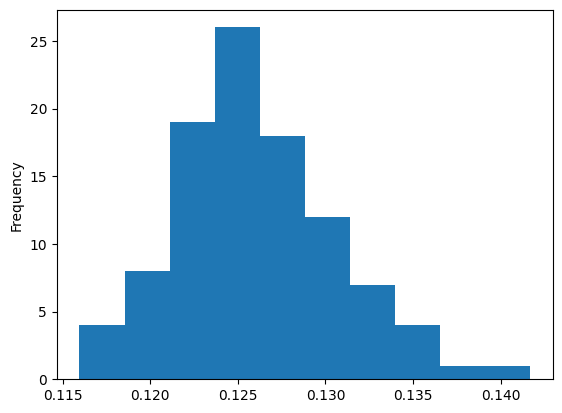

In [9]:
discount_factors=[0.1,0.3,0.5,0.7,0.9]
compactness_means=[0.1,0.3,0.5,0.7,0.9]
compactness_ranges=[0.1, 0.07,0.05,0.03]
runs = 25

column_names = ['discount_factor', 'compactness_mean', 'compactness_range', 'K_sim_mean', 'K_sim_range', 'K_sim_stdv']

df = pd.DataFrame(columns = column_names)

for factor in discount_factors:
    for cmean in compactness_means:
        for crange in compactness_ranges:
            kappas = []
            run_hindcasting(factor,cmean,crange, runs)
            pre_post_chg = chgstats('hind_2001', 'hind_2016')
                # reclassify maps to binary
            for i in range(1,runs+1):
                gs.mapcalc("hindcast_run"+str(i)+" = if(hindcast_run"+str(i)+" == -1, 0, 1)")
                gs.run_command('r.null', map='hindcast_run'+str(i), null=0)
                pre_sim_chg = chgstats('hind_2001', 'hindcast_run'+str(i))
                post_sim_diff = chgstats('hind_2016', 'hindcast_run'+str(i))
                kappas += [kappa_sim(pre_post_chg, pre_sim_chg, post_sim_diff)]

            print(sum(kappas) / len(kappas), variance(kappas), 'for parameter combination', factor, cmean, crange)
            df.loc[len(df)] = [factor, cmean, crange, sum(kappas)/runs, max(kappas) - min(kappas), variance(kappas)]
            print(len(df),"out of", len(discount_factors)*len(compactness_means)*len(compactness_ranges))

df.sort_values(by = 'K_sim_mean', axis=0, ascending=False, inplace=True)

df.to_csv('calib_kappa.csv')
df['K_sim_mean'].plot.hist()
df.head()

0.14334036348707596


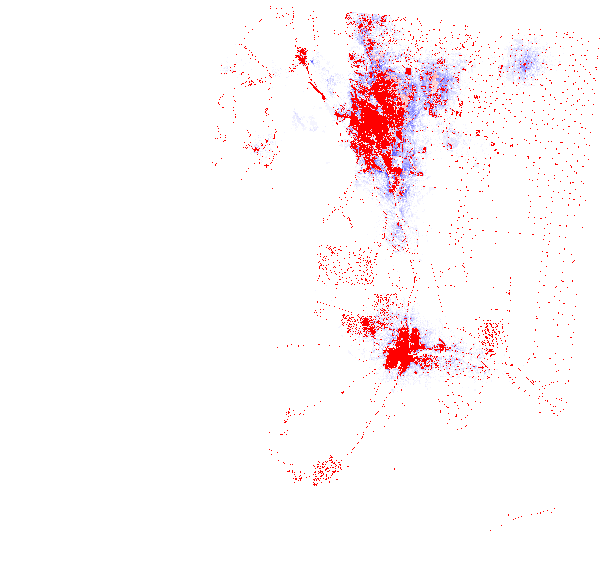

In [11]:
runs = 50
kappas = []
run_hindcasting(0.9,0.1,0.03, runs)
pre_post_chg = chgstats('hind_2001', 'hind_2016')

    # reclassify maps to binary
for i in range(1,runs+1):
    gs.mapcalc("hindcast_run"+str(i)+" = if(hindcast_run"+str(i)+" == -1, 0, 1)")
    if i > 1:
        gs.mapcalc("hind_freqmap = hind_freqmap + hindcast_run"+str(i))
    else:
        gs.mapcalc("hind_freqmap = hindcast_run"+str(i))
    gs.run_command('r.null', map='hindcast_run'+str(i), null=0)
    pre_sim_chg = chgstats('hind_2001', 'hindcast_run'+str(i))
    post_sim_diff = chgstats('hind_2016', 'hindcast_run'+str(i))
    kappas += [kappa_sim(pre_post_chg, pre_sim_chg, post_sim_diff)]

print(sum(kappas) / runs)
gs.mapcalc("hind_freqmap = hind_freqmap * if(urban_2016@PERMANENT == 1, 1, -1)")
gs.run_command('r.colors', map='hind_freqmap@Hindcasting22', color='differences')

m = gj.Map()
m.run("d.rast", map="hind_freqmap")
m.show()